/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch 1/30, Train Loss: 0.1217, Val Loss: 0.0922
Epoch 2/30, Train Loss: 0.0667, Val Loss: 0.0784
Epoch 3/30, Train Loss: 0.0594, Val Loss: 0.0733
Epoch 4/30, Train Loss: 0.0523, Val Loss: 0.0676
Epoch 5/30, Train Loss: 0.0473, Val Loss: 0.0916
Epoch 6/30, Train Loss: 0.0436, Val Loss: 0.0681
Epoch 7/30, Train Loss: 0.0407, Val Loss: 0.0777
Epoch 8/30, Train Loss: 0.0377, Val Loss: 0.0733
Epoch 9/30, Train Loss: 0.0349, Val Loss: 0.0695
Epoch 10/30, Train Loss: 0.0328, Val Loss: 0.0643
Epoch 11/30, Train Loss: 0.0319, Val Loss: 0.0697
Epoch 12/30, Train Loss: 0.0318, Val Loss: 0.0769
Epoch 13/30, Train Loss: 0.0294, Val Loss: 0.0748
Epoch 14/30, Train Loss: 0.0287, Val Loss: 0.0741
Epoch 15/30, Train Loss: 0.0276, Val Loss: 0.0751
Epoch 16/30, Train Loss: 0.0266, Val Loss: 0.0790
Epoch 17/30, Train Loss: 0.0261, Val Loss: 0.0714
Epoch 18/30, Train Loss: 0.0255, Val Loss: 0.0728
Epoch 19/30, Train Loss: 0.0249, Val Loss: 0.0741
Epoch 20/30, Train Loss: 0.0244, Val Loss: 0.0787
Epoch 21/

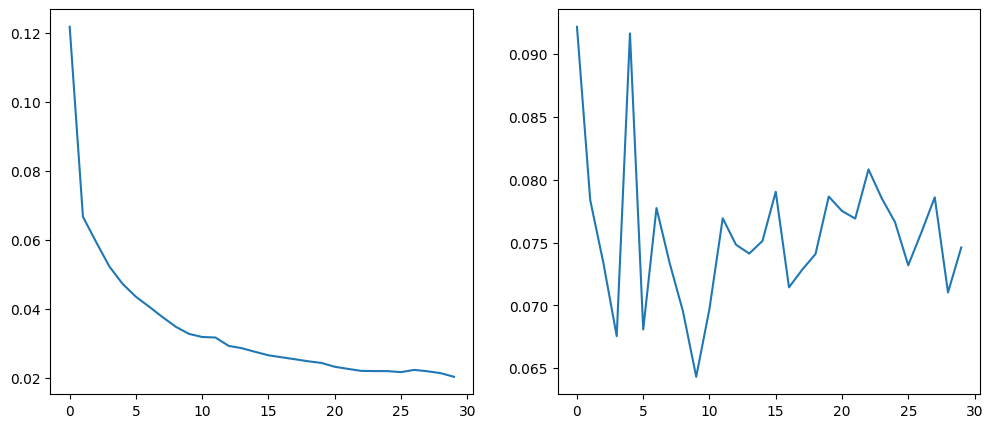

In [1]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob
import matplotlib.pyplot as plt

# Paths
DATASET_PATH = "/kaggle/input/isic2018-challenge-task1-data-segmentation"
IMAGE_DIR = os.path.join(DATASET_PATH, "ISIC2018_Task1-2_Training_Input")
MASK_DIR = os.path.join(DATASET_PATH, "ISIC2018_Task1_Training_GroundTruth")
VALIDATION_PATH = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Validation_Input"
TESTING_PATH = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Test_Input"
VALIDATION_MASK_PATH = "/kaggle/input/isic2018-validation-ground-truth/ISIC2018_Task1_Validation_GroundTruth"
TESTING_MASK_PATH = "/kaggle/input/test-groundtruth-task1/ISIC2018_Task1_Test_GroundTruth"

# Get image and mask paths
image_paths = sorted(glob.glob(IMAGE_DIR + "/*.jpg"))
mask_paths = sorted(glob.glob(MASK_DIR + "/*.png"))
validation_image_paths = sorted(glob.glob(VALIDATION_PATH + "/*.jpg"))
validation_mask_paths = sorted(glob.glob(VALIDATION_MASK_PATH + "/*.png"))
test_image_paths = sorted(glob.glob(TESTING_PATH + "/*.jpg"))
test_mask_paths = sorted(glob.glob(TESTING_MASK_PATH + "/*.png"))

# Dataset Class
class SkinLesionDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L")) / 255.0  # Normalize mask

        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

# Data Augmentation
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Create Dataset and DataLoader
train_dataset = SkinLesionDataset(image_paths, mask_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

validation_dataset = SkinLesionDataset(validation_image_paths, validation_mask_paths, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

test_dataset = SkinLesionDataset(test_image_paths, test_mask_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# CBAM Attention Mechanism
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = self.sigmoid(avg_out + max_out)
        return x * out

# Swin Transformer + U-Net + CBAM
class SwinUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SwinUNet, self).__init__()
        self.swin_transformer = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.swin_transformer.head = nn.Identity()

        self.conv1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(512, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, out_channels, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)
        self.cbam = CBAM(512)

    def forward(self, x):
        x = self.swin_transformer.forward_features(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        x = self.cbam(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.upsample(x)

# Loss Functions
def dice_loss(pred, target, smooth=1e-6):
    intersection = torch.sum(pred * target)
    return 1 - (2. * intersection + smooth) / (torch.sum(pred) + torch.sum(target) + smooth)

def focal_loss(pred, target, alpha=0.25, gamma=2.0, smooth=1e-6):
    pred = torch.sigmoid(pred)
    target = target.float()
    bce_loss = -target * torch.log(pred + smooth) - (1 - target) * torch.log(1 - pred + smooth)
    focal_loss = alpha * torch.pow(1 - pred, gamma) * bce_loss
    return torch.mean(focal_loss)

class DiceFocalLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(DiceFocalLoss, self).__init__()
        self.alpha = alpha

    def forward(self, pred, target):
        dice = dice_loss(torch.sigmoid(pred), target)
        focal = focal_loss(pred, target)
        return self.alpha * dice + (1 - self.alpha) * focal

# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwinUNet().to(device)
criterion = DiceFocalLoss(alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training Function
def train(model, train_loader, validation_loader, criterion, optimizer, epochs=30):
    model.train()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        train_loss, val_loss = 0.0, 0.0

        # Training
        for images, masks in train_loader:
            images, masks = images.to(device), masks.unsqueeze(1).to(device).float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        with torch.no_grad():
            for images, masks in validation_loader:
                images, masks = images.to(device), masks.unsqueeze(1).to(device).float()
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()

        val_losses.append(val_loss / len(validation_loader))
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Plot Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.subplot(1, 2, 2)
    plt.plot(val_losses, label="Validation Loss")
    plt.show()

# Train the model
train(model, train_loader, validation_loader, criterion, optimizer)


In [4]:
checkpoint_path = "swin_unet_final.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, checkpoint_path)

print(f"Model checkpoint saved at {checkpoint_path}")

Model checkpoint saved at swin_unet_final.pth


In [8]:
# Save trained model as a .pth.tar checkpoint
checkpoint_path = "swin_unet_final.pth.tar"

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

torch.save(checkpoint, checkpoint_path)
print(f"Model checkpoint saved to {checkpoint_path}")


Model checkpoint saved to swin_unet_final.pth.tar


In [10]:
checkpoint = torch.load('/kaggle/working/swin_unet_final.pth.tar', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])  # Use 'model_state_dict' instead of 'state_dict'

<ipython-input-10-0878ab9c9093>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/swin_unet_final.pth.tar', map_location=device)


<All keys matched successfully>

In [11]:
check_accuracy(train_loader, model, device)

Dice score: 0.5534165940722641


In [5]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Paths for validation images and masks
validation_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Test_Input"
val_img = sorted(glob.glob(validation_path + "/*.jpg"))
mask_path = r"/kaggle/input/test-groundtruth-task1/ISIC2018_Task1_Test_GroundTruth"
val_mask = sorted(glob.glob(mask_path + "/*.png"))

val_dataset = SkinLesionDataset(image_paths=validation_path,
                            mask_paths=mask_path,transform=transform)

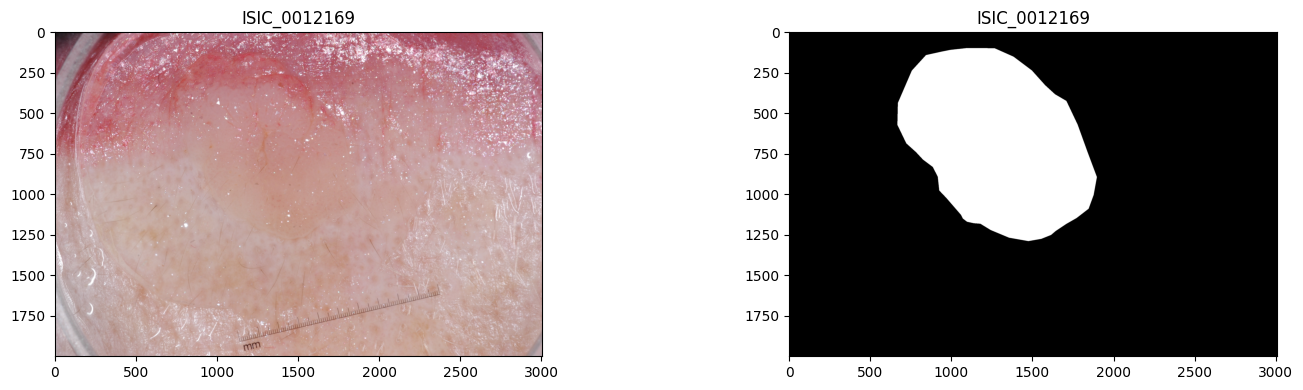

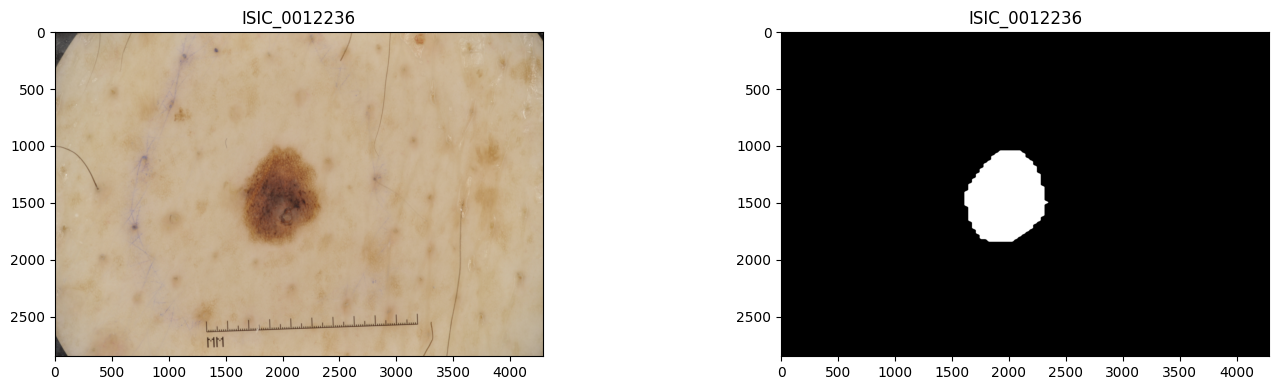

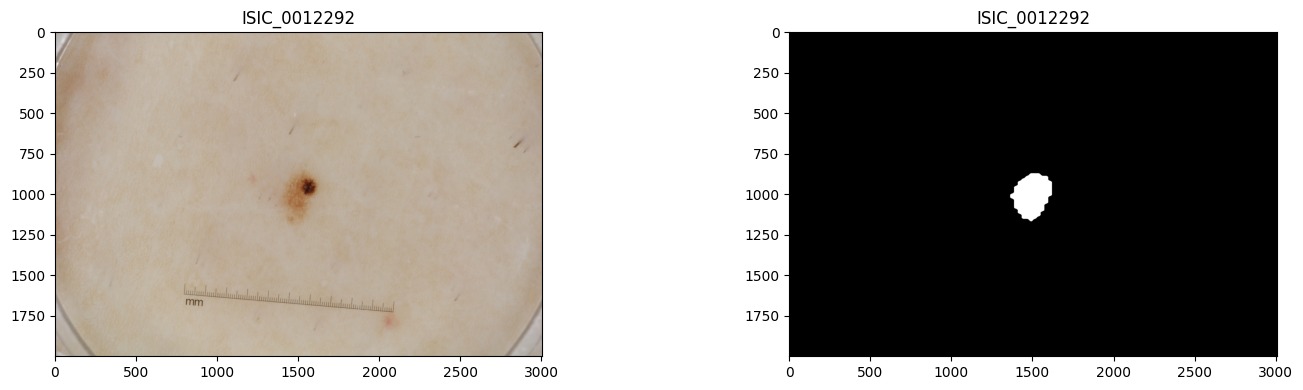

In [6]:
for i in range(3):
    samImg = cv2.imread(val_img[i])
    samMask = cv2.imread(val_mask[i])
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.title(val_img[i].split('/')[-1].rstrip(".jpg"))
    plt.imshow(cv2.cvtColor(samImg,cv2.COLOR_BGR2RGB))
    
    plt.subplot(1,2,2)
    plt.title(val_mask[i].split('/')[-1].rstrip("_segmentation.png"))
    plt.imshow(samMask)
    plt.tight_layout()
    plt.show()

In [7]:
# Define the transformation (resize, normalization) if needed

def preprocess_image(image_path, size,device):
    # Load image with OpenCV
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB if needed

    # Resize the image if needed
    img_resized = cv2.resize(img, (size, size))

    # Convert image to float and normalize (assuming the model expects 0-1 range)
    img_resized = img_resized / 255.0

    # Convert to torch tensor and move to the specified device
    img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    return img_tensor

In [24]:
# Initialize lists for storing metrics
imgId, dice_scores, iou_scores, sensitivities, specificities = [], [], [], [], []
size = 224

# Loop through validation images and evaluate each one
for i in range(len(val_img)):
    # Preprocess the image
    img_tensor = preprocess_image(val_img[i], size, device)
    with torch.no_grad():
        # Get predicted mask
        generated_mask = model(img_tensor).squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy
    
    # Load and resize true mask for comparison
    true_mask = cv2.imread(val_mask[i], cv2.IMREAD_GRAYSCALE)
    true_mask_resized = cv2.resize(true_mask, (generated_mask.shape[1], generated_mask.shape[0]))

    # Binarize masks for metric calculations
    threshold = 0.5
    true_mask_bin = (true_mask_resized > threshold).astype(np.uint8)
    generated_mask_bin = (generated_mask > threshold).astype(np.uint8)

    # Calculate metrics (Dice, IoU, Sensitivity, Specificity)
    intersection = np.sum(true_mask_bin * generated_mask_bin)
    dice_score = (2 * intersection) / (np.sum(true_mask_bin) + np.sum(generated_mask_bin))
    dice_scores.append(dice_score)
    
    union = np.sum(true_mask_bin) + np.sum(generated_mask_bin) - intersection
    iou = intersection / union if union != 0 else 0
    iou_scores.append(iou)
    
    true_positive = np.sum((true_mask_bin == 1) & (generated_mask_bin == 1))
    false_negative = np.sum((true_mask_bin == 1) & (generated_mask_bin == 0))
    sensitivity = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    sensitivities.append(sensitivity)
    
    true_negative = np.sum((true_mask_bin == 0) & (generated_mask_bin == 0))
    false_positive = np.sum((true_mask_bin == 0) & (generated_mask_bin == 1))
    specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) != 0 else 0
    specificities.append(specificity)
    
    # Store image id and scores
    imgId.append(val_img[i].split('/')[-1].rstrip(".jpg"))

In [25]:
# Compile results into a DataFrame
df = pd.DataFrame({
    "img_id": imgId,
    "dice_score": dice_scores,
    "jaccard_index": iou_scores,
    "sensitivity": sensitivities,
    "specificity": specificities
})

In [26]:
print(df)

           img_id  dice_score  jaccard_index  sensitivity  specificity
0    ISIC_0012169    0.588206       0.416638     0.421882     0.997433
1    ISIC_0012236    0.915927       0.844894     0.864729     0.999132
2    ISIC_0012292    0.852753       0.743304     0.753394     0.999879
3    ISIC_0012302    0.927911       0.865517     0.869802     0.999792
4    ISIC_0012337    0.920762       0.853160     0.965300     0.997461
..            ...         ...            ...          ...          ...
995  ISIC_0036343    0.912354       0.838833     0.999578     0.940744
996  ISIC_0036344    0.864865       0.761905     1.000000     0.993490
997  ISIC_0036345    0.968551       0.939020     0.987930     0.891651
998  ISIC_0036346    0.951613       0.907692     0.909375     0.998882
999  ISIC_0036347    0.856263       0.748654     1.000000     0.874788

[1000 rows x 5 columns]


In [30]:
#os.remove("/kaggle/working/checkpoint_epoch_15.pth.tar")

In [31]:
df.to_excel("result_analysis.xlsx")

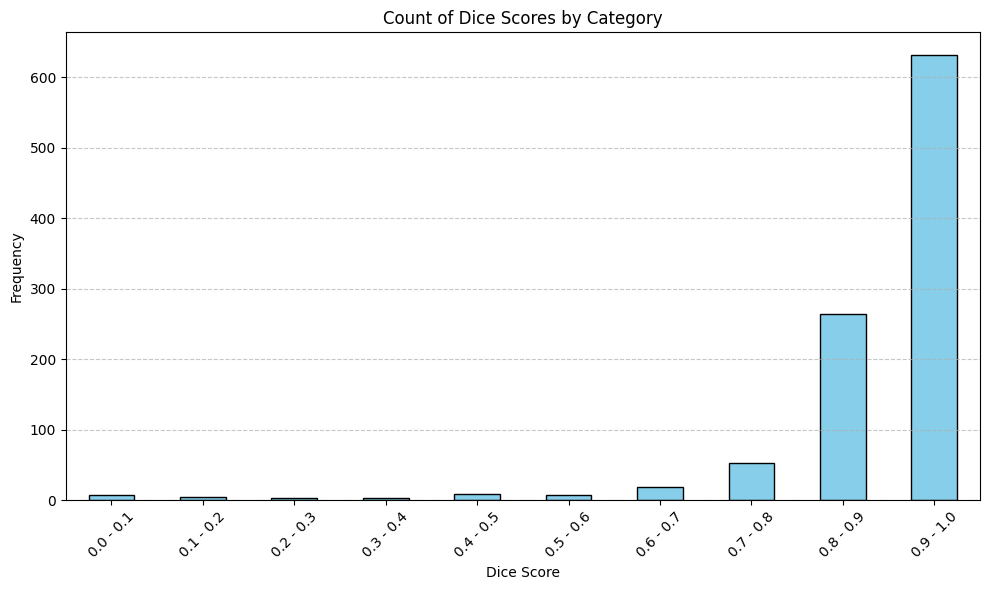

In [32]:
# Plot Dice Score Distribution
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0.0 - 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.4',
          '0.4 - 0.5', '0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8',
          '0.8 - 0.9', '0.9 - 1.0']

df['Category'] = pd.cut(df['dice_score'].round(2), bins=bins, labels=labels, right=False)
category_counts = df['Category'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of Dice Scores by Category')
plt.xlabel('Dice Score')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

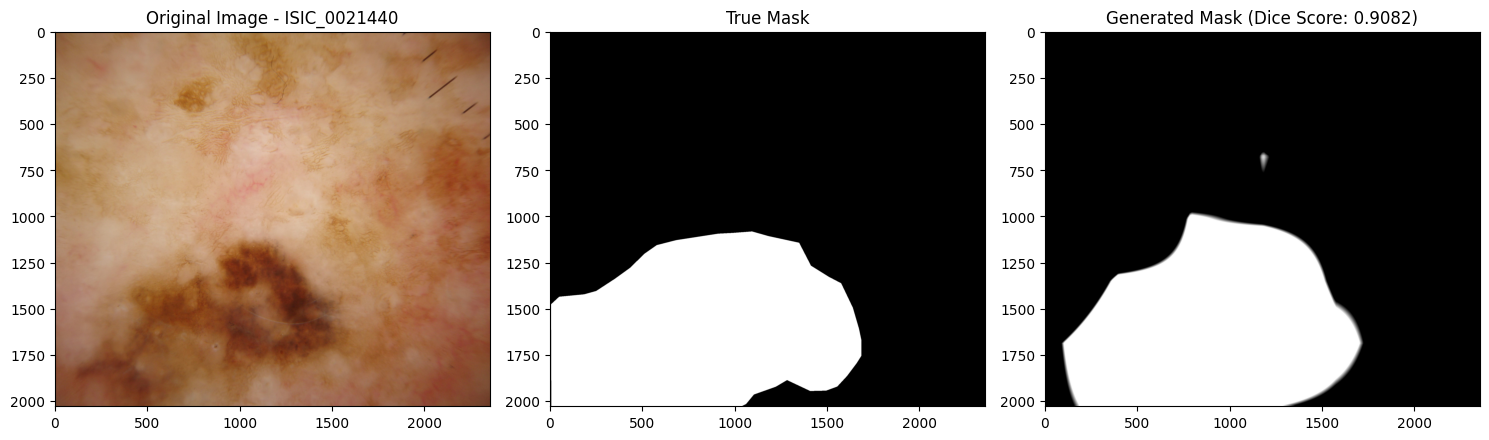

In [34]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def manual_check_single_image(image_idx=0):
    # Load the image path and true mask path
    img_path = val_img[image_idx]
    mask_path = val_mask[image_idx]
    
    # Load and preprocess the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img_resized = cv2.resize(img, (size, size)) / 255.0  # Resize and normalize

    # Load the true mask
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask_resized = cv2.resize(true_mask, (size, size))

    # Convert image to tensor and move to the device
    img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().to(device)

    # Generate the mask with the model
    with torch.no_grad():
        generated_mask = model(img_tensor).squeeze().cpu().numpy()

    # Resize generated mask back to original image size for visualization
    generated_mask_resized = cv2.resize(generated_mask, (img.shape[1], img.shape[0]))
    true_mask_resized = cv2.resize(true_mask, (img.shape[1], img.shape[0]))

    # Stack the masks for visualization
    true_mask_stacked = np.stack((true_mask_resized,) * 3, axis=-1)
    generated_mask_stacked = np.stack((generated_mask_resized,) * 3, axis=-1)

    # Calculate Dice Score
    threshold = 0.5
    true_mask_bin = (true_mask_resized > threshold).astype(np.uint8)
    generated_mask_bin = (generated_mask_resized > threshold).astype(np.uint8)
    intersection = np.sum(true_mask_bin * generated_mask_bin)
    dice_score = (2 * intersection) / (np.sum(true_mask_bin) + np.sum(generated_mask_bin))

    # Image ID
    img_id = img_path.split('/')[-1].rstrip(".jpg")

    # Plot original image, true mask, and generated mask
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title(f'Original Image - {img_id}')
    ax[1].imshow(true_mask_stacked, cmap='gray')
    ax[1].set_title('True Mask')
    ax[2].imshow(generated_mask_stacked, cmap='gray')
    ax[2].set_title(f'Generated Mask (Dice Score: {dice_score:.4f})')
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Call the function to display the results for a single image
manual_check_single_image(image_idx=479)


In [ ]:

# import torch
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from reportlab.lib.pagesizes import letter
# from reportlab.pdfgen import canvas
# import os

# def manual_check_to_pdf(start_idx=0, num_images=100, pdf_filename="image_report.pdf"):
#     pdf = canvas.Canvas(pdf_filename, pagesize=letter)
#     width, height = letter
#     y_position = height - 40  # Initial position from top of the page
    
#     for ind in range(start_idx, start_idx + num_images):
#         # Load the image path and true mask path based on the index
#         img_path = val_img[ind]
#         mask_path = val_mask[ind]
        
#         # Load and preprocess the image
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
#         img_resized = cv2.resize(img, (size, size)) / 255.0  # Resize and normalize to 0-1
        
#         # Load the true mask
#         true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#         true_mask_resized = cv2.resize(true_mask, (size, size))
        
#         # Convert image to tensor and move to the device
#         img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().to(device)
        
#         # Generate the mask with the model
#         with torch.no_grad():
#             generated_mask = model(img_tensor).squeeze().cpu().numpy()

#         # Resize generated mask back to original image size for visualization
#         generated_mask_resized = cv2.resize(generated_mask, (img.shape[1], img.shape[0]))
#         true_mask_resized = cv2.resize(true_mask, (img.shape[1], img.shape[0]))

#         # Stack the masks for visualization
#         true_mask_stacked = np.stack((true_mask_resized,) * 3, axis=-1)
#         generated_mask_stacked = np.stack((generated_mask_resized,) * 3, axis=-1)

#         # Calculate Dice Score
#         threshold = 0.5
#         true_mask_bin = (true_mask_resized > threshold).astype(np.uint8)
#         generated_mask_bin = (generated_mask_resized > threshold).astype(np.uint8)

#         intersection = np.sum(true_mask_bin * generated_mask_bin)
#         dice_score = (2 * intersection) / (np.sum(true_mask_bin) + np.sum(generated_mask_bin))

#         # Image ID
#         img_id = img_path.split('/')[-1].rstrip(".jpg")

#         # Plot original image, true mask, and generated mask
#         fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#         ax[0].imshow(img)
#         ax[0].set_title(f'Original Image - {img_id}')
#         ax[1].imshow(true_mask_stacked, cmap='gray')
#         ax[1].set_title('True Mask')
#         ax[2].imshow(generated_mask_stacked, cmap='gray')
#         ax[2].set_title('Generated Mask')
#         plt.tight_layout()

#         # Save the plot as an image
#         plot_filename = f"temp_plot_{img_id}.png"
#         plt.savefig(plot_filename, bbox_inches='tight', dpi=150)
#         plt.close()

#         # Add the plot image to the PDF
#         if y_position - 150 < 40:  # Check if there's enough space for the next image
#             pdf.showPage()  # Add a new page
#             y_position = height - 40  # Reset the Y position
        
#         pdf.drawImage(plot_filename, 40, y_position - 150, width=500, height=150)
        
#         # Add the Dice Score text below the image
#         pdf.setFont("Helvetica", 10)
#         y_position -= 160  # Move down to leave space for the text
#         pdf.drawString(40, y_position, f"Image ID: {img_id}")
#         pdf.drawString(40, y_position - 20, f"Dice Score: {dice_score:.4f}")
        
#         # Move Y position down for next entry
#         y_position -= 40
        
#         # Clean up by deleting the temporary image
#         os.remove(plot_filename)

#     # Save the final PDF
#     pdf.save()
#     print(f"PDF saved as {pdf_filename}")

# # Call the function to generate the PDF report for 100 images starting from index 0
# manual_check_to_pdf(start_idx=0, num_images=100, pdf_filename="image_report.pdf")


In [23]:
pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
